In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torch
import scipy as sp
import json
import numpy as np
from glob import glob
import anndata
import pandas as pd 
from src.vae import CrossSpeciesVAE
from src.data import CrossSpeciesDataModule
import pickle
from sklearn.metrics import adjusted_mutual_info_score
import scanpy as sc
import matplotlib.pyplot as plt
import umap

fn1 = '../samap/example_data/planarian.h5ad'
fn2 = '../samap/example_data/schistosome.h5ad'
fn3 = '../samap/example_data/hydra.h5ad'

eggnogs = '../samap/example_data/eggnog/*'

adata1 = anndata.read_h5ad(fn1)
adata2 = anndata.read_h5ad(fn2)
adata3 = anndata.read_h5ad(fn3)
adata3.var_names = pd.Index([i.split('_')[-1] for i in adata3.var_names])

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# gene_embeddings, gene_ids = pickle.load(open('species_tsvd_gene_embeddings.pkl','rb'))
# gene_embeddings={k: torch.tensor(v) for k,v in gene_embeddings.items()}

batch_size = 128
species_data = {
    "planarian": adata1,
    "schisto": adata2,
    "hydra": adata3,
}

data_module = CrossSpeciesDataModule(
    species_data = species_data,
    batch_size=batch_size,
    num_workers=0,
    val_split=0.1,
    test_split=0.1,
    seed=0
)
data_module.setup()

species_vocab_sizes = data_module.species_vocab_sizes

# Initialize the model using data module properties
model = CrossSpeciesVAE(
    species_vocab_sizes=species_vocab_sizes,
    # homology_edges=homology_edges,
    # homology_scores=homology_scores,
    # gene_embeddings=gene_embeddings,
    n_latent=128,
    hidden_dims=[128],
    dropout_rate=0.2,
    base_learning_rate=1e-3,
    batch_size=batch_size,
    base_batch_size=32,
    min_learning_rate=1e-5,
    warmup_epochs=1.0,
    species_embedding_dim=32,
    init_beta=1e-3,
    final_beta=1,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    # loss weights
    recon_weight=1.0,
    adversarial_weight=0.01,
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=20,
    verbose=True,
    mode='min'
)

# Initialize the trainer
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=100,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=10,
    deterministic=True,
    callbacks=[ModelCheckpoint(
        dirpath="checkpoints",
        filename="crossspecies_vae_stage1-{epoch:02d}",
        every_n_epochs=5,
        save_top_k=1,
        monitor="val_loss",
        mode="min"
    ), early_stopping],
    accumulate_grad_batches=len(species_vocab_sizes),  # Number of species
    enable_progress_bar=False,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [3]:
trainer.fit(model, data_module)

You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /opt/jupyter-envs/generate-cross-species/atar-vscode/work/cross-species-vae/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                      | Type                 | Params | Mode 
---------------------------------------------------------------------------
0 | mu_layer                  | Linear               | 16.5 K | train
1 | logvar_layer              | Linear               | 16.5 K | train
2 | decoder_species_embedding | Em

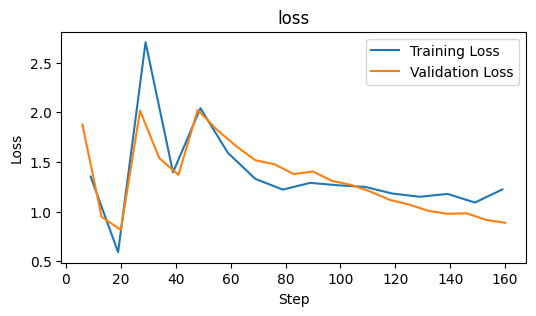

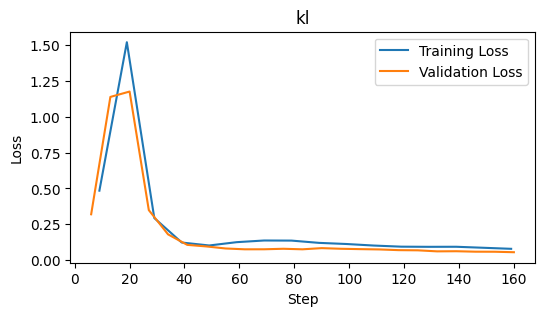

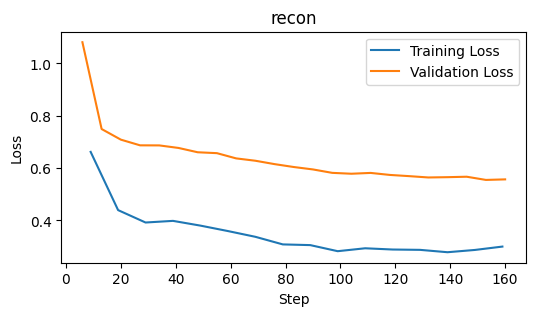

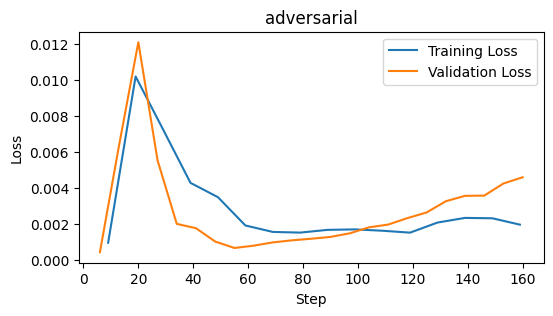

In [4]:
# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["loss", "kl", "recon", "adversarial"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}']
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}']
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(df['step'][f1], train_loss[f1], label='Training Loss')
    plt.plot(df['step'][f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

    
# best_model_path = trainer.callbacks[-1].best_model_path
# print("Best model path:", best_model_path)
# # Load the checkpoint
# checkpoint = torch.load(best_model_path)

# # Create a new model with the same hyperparameters and homology information
# model = CrossSpeciesVAE(
#     # homology_edges=homology_edges,  # Need to pass these again
#     **checkpoint['hyper_parameters']  # This loads all other hyperparameters
# )

# # Load the state dict
# model.load_state_dict(checkpoint['state_dict'])

In [ ]:


output, s = model.get_latent_embeddings(species_data)
s=s.cpu().numpy()

plt.figure();
dt = umap.UMAP(n_components=2).fit_transform(output.cpu().numpy())
plt.scatter(dt[:,0],dt[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1, 2], [adata1, adata2, adata3], ['cluster', 'cluster_t', 'Cluster']):
    dt = umap.UMAP(n_components=2).fit_transform(output[s==i])

    adata.obsm['emb'] = dt
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
    plt.figure();
    plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    

0.5785376706444819
0.4232237165830029


In [6]:
from scipy.stats import spearmanr

for i, adata in enumerate([adata1, adata2, adata3]):
    x = model.encoders[str(i)].gene_importance(torch.tensor(adata.X.toarray()).to('cuda')).detach().cpu().numpy()
    mu = x.mean(0)
    mu[mu==0]=1
    a = x.var(0)/mu
    b = adata.var['weights'].values

    # plt.figure(); plt.scatter(a,b,s=1);
    # plt.figure(); plt.scatter(x.var(0),adata.X.toarray().var(0),s=1);    
    print(i)
    print('pearson',np.corrcoef(a,b)[0,1])
    print('spearman',spearmanr(a,b).statistic)


0
pearson 0.3892610035514709
spearman 0.3814591561200647
1
pearson 0.3800080359716171
spearman 0.2883485945561549
2
pearson 0.6561173240269343
spearman 0.8555250438072001


In [34]:
import numpy as np
from pynndescent import NNDescent

def find_nearest_neighbors(L1, L2, n_neighbors=5, metric='euclidean'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

latent = output.cpu().numpy()

In [50]:
from torch.functional import F

species1_id = 0
species2_id = 1

edges = model.homology_edges[species1_id][species2_id]
weights = F.softplus(model.homology_scores[str(species1_id)][str(species2_id)])

expr1 = adata1.X.toarray()
expr2 = adata2.X.toarray()

expr1_homolog = expr1[:, edges[:, 0]] * weights.detach().cpu().numpy()[None, :]
expr2_homolog = expr2[:, edges[:, 1]] * weights.detach().cpu().numpy()[None, :]

In [56]:
expr1_centered = expr1_homolog - expr1_homolog.mean(axis=1)[:,None]
expr2_centered = expr2_homolog - expr2_homolog.mean(axis=1)[:,None]

std1 = expr1_centered.std(axis=1)[:,None]
std2 = expr2_centered.std(axis=1)[:,None]

In [89]:
A = np.corrcoef(np.vstack((expr1_homolog,expr2_homolog)))

In [85]:
A[:std1.size,:std1.size]=0
A[std1.size:,std1.size:]=0

In [97]:
dt = umap.UMAP(metric='precomputed').fit_transform(1-A)

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [83]:
s1=s[s!=2]

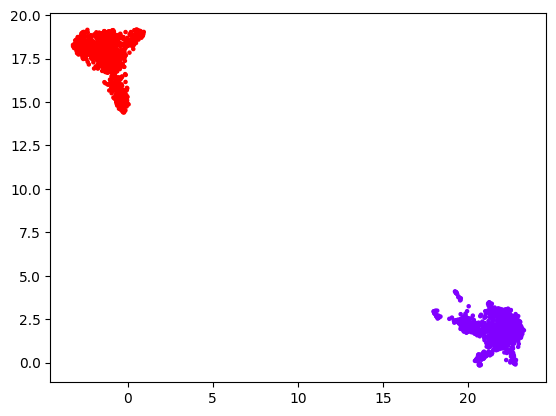

In [98]:
plt.figure(); plt.scatter(dt[:,0],dt[:,1], c=s1, s = 5, cmap='rainbow')

np.float64(1.0)

In [ ]:
expr1_centered = expr1_homolog - expr1_homolog.mean(dim=1, keepdim=True)
expr2_centered = expr2_homolog - expr2_homolog.mean(dim=1, keepdim=True)

std1 = expr1_centered.std(dim=1, keepdim=True)
std2 = expr2_centered.std(dim=1, keepdim=True)
correlations = (expr1_centered * expr2_centered).mean(dim=1) / (std1 * std2 + 1e-8)

In [35]:
indices,distances = find_nearest_neighbors(latent[s==0],latent[s==1])

In [36]:
c1 = np.array(list(adata1.obs['tissue']))
c2 = np.array(list(adata2.obs['tissue']))
c1 = c1[np.tile(np.arange(c1.size)[:,None],(1,5))]
c2 = c2[indices]

In [37]:
c1[:20]

array([['Intestine', 'Intestine', 'Intestine', 'Intestine', 'Intestine'],
       ['Intestine', 'Intestine', 'Intestine', 'Intestine', 'Intestine'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Cathepsin+ cells', 'Cathepsin+ cells', 'Cathepsin+ cells',
        'Cathepsin+ cells', 'Cathepsin+ cells'],
       ['Neural', 'Neural', 'Neural', 'Neural', 'Neural'],
       ['Neural', 'Neural', 'Neural', 'Neural', 'Neural'],
       ['Cathepsin+ cells', 'Cathepsin+ cells', 'Cathepsin+ cells',
        'Cathepsin+ cells', 'Cathepsin+ cells'],
       ['Muscle', 'Muscle', 'Muscle', 'Muscle', 'Muscle'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epi

In [38]:
c2[:20]

array([['Parenchymal', 'Neoblast', 'Neoblast', 'Neural', 'Intestine'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Parenchymal', 'Neoblast', 'Neoblast', 'Neural', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Neural', 'Muscle', 'Parenchymal', 'Neoblast', 'Neural'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neural', 'Neoblast'],
       ['Parenchymal', 'Neoblast', 'Tegument_prog', 'Neural', 'Neoblast'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neural', 'Neoblast'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Parenchymal', 'Neural', 'Neoblast', 'Neoblast', 'Intestine'],
       ['Ne